In [2]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import statsmodels.api as sm
import numpy as np
import geopandas as gpd
from matplotlib import pyplot as plt
import matplotlib.ticker
from haversine import haversine_vector, Unit
pd.options.mode.chained_assignment = None  # default='warn'
from sttn.data.lehd import OriginDestinationEmploymentDataProvider
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
provider = OriginDestinationEmploymentDataProvider()
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
import seaborn as sns

import math
from sttn.network import SpatioTemporalNetwork
from sttn.utils import add_distance
import os
%matplotlib inline

In [10]:
cities = [
    ('New York City', 'ny', ['New York County, NY', 'Queens County, NY','Kings County, NY','Bronx County, NY','Richmond County, NY']),
    ('Los Angeles', 'ca', ['Los Angeles County, CA']),
    ('Chicago', 'il', ['Cook County, IL']),
    ('Houston', 'tx', ['Harris County, TX']),
    ('Boston', 'ma', ['Suffolk County, MA', 'Middlesex County, MA']),
    ('Phoenix', 'az', ['Maricopa County, AZ']),
    ('Philadelphia', 'pa', ['Philadelphia County, PA']),
    ('San Antonio', 'tx', ['Bexar County, TX']),
    ('San Diego', 'ca', ['San Diego County, CA']),
    ('Dallas', 'tx', ['Dallas County, TX']),
    ('San Jose', 'ca', ['Santa Clara County, CA']),
    ('Austin', 'tx', ['Travis County, TX']),
]

In [23]:
def build_training_set(network, target_column):
    # explode the dataset to include all node pairs
    node_ids = network.nodes.index.values
    origins = pd.DataFrame(node_ids, columns = ['origin'])
    destinations = pd.DataFrame(node_ids, columns = ['destination'])
    cartesian_product = origins.merge(destinations, how='cross')
    
    # compute distnace between all pairs
    centroid = network.nodes.centroid
    centroid_long = centroid.x
    centroid_long.name = 'long'
    centroid_lat = centroid.y
    centroid_lat.name = 'lat'
    centroids = pd.concat([centroid_long, centroid_lat], axis=1)
    centroid_from = cartesian_product.join(centroids, on=network._origin).rename(columns={'long': 'long_from', 'lat': 'lat_from'})
    centroid_all = centroid_from.join(centroids, on=network._destination).rename(columns={'long': 'long_to', 'lat': 'lat_to'})
    from_points = list(zip(centroid_all.lat_from, centroid_all.long_from))
    to_points = list(zip(centroid_all.lat_to, centroid_all.long_to))
    centroid_all['distance'] = haversine_vector(from_points, to_points, Unit.KILOMETERS)
    centroid_all.drop(['long_from', 'lat_from', 'long_to', 'lat_to'], axis=1, inplace=True)
#     print(centroid_all.columns)
    centroid_above = centroid_all.loc[centroid_all.distance > 0]
    centroid_below = centroid_all.loc[centroid_all.distance == 0]
    del centroid_below['distance']
    misDistance = centroid_above.groupby(['origin']).agg({'distance':min})
    misDistance['distance'] = misDistance['distance']
    centroid_below = centroid_below.merge(misDistance,on=['origin'])
#     centroid_all.loc[centroid_all.distance == 0, 'distance'] = centroid_all.loc[centroid_all.distance > 0, 'distance'].min()*0.5
    centroid_all = pd.concat([centroid_above,centroid_below],axis=0)
    # compute jobs and residence
    comp_aggs={target_column: 'sum'}
    jobs = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=False).rename(columns={target_column: 'jobs'})
    residence = network.agg_adjacent_edges(aggs=comp_aggs, outgoing=True).rename(columns={target_column: 'residence'})
    features = centroid_all.join(residence, on='origin').join(jobs, on='destination')
    
    # merge flow data
    flow = network.edges.rename(columns={target_column: 'flow'})[['origin', 'destination', 'flow']]
    combined = features.merge(flow, how='left', on=['origin', 'destination']).fillna(0)
    
    return combined

In [24]:
# change here to age groups
target_columns = ['S000','SE01','SE03']
for city, state, conties in cities:
    
    print(city)
    state_network = provider.get_data(state=state, year=2018)
    city_network = state_network.filter_nodes(state_network.nodes.county.isin(conties))
    for target_column in target_columns:
        training_set = build_training_set(city_network, target_column)
        training_set.to_csv(f'{target_column}/{city}.csv',index=False)

New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego
Dallas
San Jose
Austin


In [25]:
for city, state, conties in cities:
    df0 = pd.read_csv(f'S000/{city}.csv')
    df1 = pd.read_csv(f'SE01/{city}.csv')
    df3 = pd.read_csv(f'SE03/{city}.csv')
    df0.rename(columns={'jobs':'S000jobs', 'residence':'S000residence','flow':'S000flow'}, inplace=True)
    df1.rename(columns={'jobs':'SE01jobs', 'residence':'SE01residence','flow':'SE01flow'}, inplace=True)
    df3.rename(columns={'jobs':'SE03jobs', 'residence':'SE03residence','flow':'SE03flow'}, inplace=True)
    merged = df0.merge(df1,on=['origin','destination'],how='outer').merge(df3,on=['origin','destination'],how='outer')
    merged.to_csv(f'income/{city}.csv', index=False)

# baseline

### unconstrain model, power law

In [3]:
def power_law(x,k,a):
    return k*((x[:,0]**a)*x[:,1]*x[:,2])
def baseline_fit(df,target):
    X = ['distance',target+'jobs',target+'residence']
    y = target+'flow'
    pars, cov = optimize.curve_fit(f=power_law, xdata=df[X].values, ydata=df[y].values, bounds=(-np.inf, np.inf))
    return pars
def baseline_predict(test,target,pars):
    test[target+'k'] = pars[0]
    test[target+'a'] = pars[1]
    test[target+'pred'] = test[target+'k']*(test['distance']**test[target+'a'])*test[target+'jobs']*test[target+'residence']
    return test

## f(d)

In [4]:
def unconstrained_bucked_constant_kfit(data, target):
    binf = {}
    X = data[target+'jobs'].values*data[target+'residence'].values
    y = data[target+'flow'].values
    model = sm.OLS(y,X)
    results = model.fit()
    k = results.params[0]
    data[target+'k'] = k
    # estimate F for each bin
    for b in data['bin'].unique():
        subData = data[data['bin'] == b]
        X = subData[target+'k']*subData[target+'jobs'].values*subData[target+'residence'].values
        y = subData[target+'flow'].values
        model = sm.OLS(y,X)
        results = model.fit()
        subData[target+'f'] = results.params[0]
        binf[b] = (results.params[0],subData['distance'].median())
    return (binf,k)
def unconstrained_bucked_constant_kpredict(test,target,k,binf):
    test[target+'k'] = k
    test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'f']*test[target+'jobs']*test[target+'residence']
    return test

## linear f(d)

In [19]:
def unconstrained_bucked_linear_kpredict(test,target,k,binf):
    
    # linear interpolation to get f(d) value for each distance value
    # backfill to fill values for values in the fisrt and last half bins
    binfdf_interpolation = pd.DataFrame(binf).T
    binfdf_interpolation.columns = ['f(d)','distance']
    binfdf_interpolation['bin'] = binf.keys()
    binfdf_interpolation =  pd.concat([test[['distance']].drop_duplicates(),
                                       binfdf_interpolation]).sort_values(by='distance')
    binfdf_interpolation = binfdf_interpolation.set_index('distance')
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)'].interpolate(method='index')
    binfdf_interpolation = binfdf_interpolation.reset_index()
    binfdf_interpolation['f(d)inter'] = binfdf_interpolation['f(d)inter'].fillna(method='backfill')
    binfdf_interpolation = binfdf_interpolation[['distance','f(d)inter']]
    binfdf_interpolation.columns = ['distance',target+'_f(d)inter']
    
    test = test.merge(binfdf_interpolation,on='distance',how='left')
    test[target+'k'] = k
#     test[target+'f'] = test['bin'].apply(lambda x:binf[x][0])
    test[target+'pred'] = test[target+'k']*test[target+'_f(d)inter']*test[target+'jobs']*test[target+'residence']
    return test

## Normalize bin

In [20]:
def locBin(x,distBin):
    if x >= distBin[0] and x <= distBin[-1]:
        for i,num in enumerate(distBin):
            if x >= distBin[i] and x<= distBin[i+1]:
                return i
    else:
        raise Exception(f'Can not find bin for {x}')

# start point

In [21]:
citieeList = ['New York City','Los Angeles','Chicago','Houston',
          'Boston','Phoenix','Philadelphia','San Antonio','San Diego']
points = [0.480595,1.118437,1.02187,1.809567,1.662374,1.837157,0.731242,2.082544,1.99236]
startPoints = dict(zip(citieeList, points))

## find optimal bin

#### determined to use 40 bins from the figure above

In [22]:
# expand bin to include the nearest datapoints
def mergeBin(df,rate,number):
    df = df.sort_values(by=['distance']).reset_index(drop=True)
    pad = pd.DataFrame()
#     thre = max(int(0.0007*len(df)),1500)
#     thre = max(int(0.01*len(df)),2000)
    thre = max(int(rate*len(df)),number)


    for binNo in df.bin.unique():
        # not enough datapoints in a bin
        if len(df.loc[df['bin']==binNo]) < thre:
            # index of current bin
            indexes = df.loc[df['bin']==binNo].index.values.astype(int)
            # how many datapoints are needed from other bins
            addedVolume = thre - len(df.loc[df['bin']==binNo])
            
            # do we have enough datapoints on the left side
            if indexes[0] > int(addedVolume/2):
                # left side
                padTemp = df.iloc[indexes[0] - int(addedVolume/2): indexes[0]]
                                            # right side
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]:indexes[-1] + int(addedVolume/2)]])
                padTemp['bin'] = binNo
#                 print(indexes[0] - int(addedVolume/2), indexes[0],indexes[-1],indexes[-1] + int(addedVolume/2), binNo)
            else:
                padTemp = df.iloc[:indexes[0]]
                padTemp = pd.concat([padTemp,df.iloc[indexes[-1]: addedVolume+indexes[-1]]])
                padTemp['bin'] = binNo
#                 print(indexes[0],indexes[-1], addedVolume-indexes[0]+indexes[-1],binNo)
            pad = pd.concat([pad,padTemp])
    df = pd.concat([df,pad])
    return df

In [220]:


# 5-fold 
resultslfd40is = {}
resultslfd40os = {}


resultsBaselineis = {}
resultsBaselineos = {}
rate, number = 0.002,2000
for bins in np.linspace(10,50,9):
    print(bins)
    bins = int(bins)
    resultslfd40is[bins] = {}
    resultslfd40os[bins] = {}
    resultsBaselineis[bins] = {}
    resultsBaselineos[bins] = {}
    for city,state, counties in cities:
        if city in citieeList:
            print(city)
            df = pd.read_csv(f'income/{city}.csv')
            df['distance'] = df['distance']/1.6
            startpoint = startPoints[city]/1.6
            # include 95% of distance 
            startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
            afterendpointPercentage = 0.05 - startpointPercentage
            endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
            df = df.loc[(df['distance']>startpoint)&(df['distance']<endpoint)]
            df['logDist'] = np.log(df['distance'])
     
            
            distBin = np.linspace(np.log(startpoint),np.log(endpoint),bins+1)
            df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
            df = mergeBin(df,rate,number)

            skf = StratifiedKFold(n_splits=5)
            skf.get_n_splits(df.drop(columns='bin',axis=1), df['bin'])
                # fd
            for target in ['S000']:
                print(target)

                fdmseis = 0
                fdmseos = 0
                lfdmseis = 0
                lfdmseos = 0
                blmseis = 0
                blmseos = 0
                for train_index, test_index in skf.split(df.drop(columns='bin',axis=1), df['bin']):
                    traindf, testdf = df.iloc[train_index], df.iloc[test_index]
                    binf,k = unconstrained_bucked_constant_kfit(traindf, target)

                    # linear interpolated f(d), include distance in formulation
                    df_lfdis = unconstrained_bucked_linear_kpredict(traindf,target,k,binf)
                    df_lfdos = unconstrained_bucked_linear_kpredict(testdf,target,k,binf)

                    lfdmseis += mean_squared_error(df_lfdis[target+'flow'],df_lfdis[target+'pred'])
                    lfdmseos += mean_squared_error(df_lfdos[target+'flow'],df_lfdos[target+'pred'])


                # baseline 
                    pars = baseline_fit(traindf,target)
                    df_baselineis = baseline_predict(traindf,target,pars)
                    df_baselineos = baseline_predict(testdf,target,pars)
                    blmseis += mean_squared_error(df_baselineis[target+'flow'],df_baselineis[target+'pred'])
                    blmseos += mean_squared_error(df_baselineos[target+'flow'],df_baselineos[target+'pred'])


                resultslfd40is[bins][city] = resultslfd40is.get(city,[])+ [lfdmseis/5]
                resultslfd40os[bins][city] = resultslfd40os.get(city,[])+ [lfdmseos/5]

                resultsBaselineis[bins][city] = resultsBaselineis.get(city,[]) + [blmseis/5]
                resultsBaselineos[bins][city] = resultsBaselineos.get(city,[]) + [blmseos/5]


10.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
15.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
20.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
25.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
30.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
35.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
40.0
New York City
S000
Los Angeles
S000
Chicago
S000
Houston
S000
Boston
S000
Phoenix
S000
Philadelphia
S000
San Antonio
S000
San Diego
S000
45.0
N

In [221]:
resultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultslfd40os[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    resultsdf = pd.concat([resultsdf,temp])

blresultsdf = pd.DataFrame()
for bins in resultsBaselineos.keys():
    temp = pd.DataFrame(resultsBaselineos[bins])
    temp.columns =  citieeList
    temp['bins'] = bins
    blresultsdf = pd.concat([blresultsdf,temp])

In [222]:
citiBin = {}
for city in citieeList:
    index = np.argmin((resultsdf[city] - blresultsdf[city]).values)
    citiBin[city] = resultsdf['bins'].values[index]
citiBin

{'New York City': 50,
 'Los Angeles': 30,
 'Chicago': 40,
 'Houston': 40,
 'Boston': 20,
 'Phoenix': 30,
 'Philadelphia': 50,
 'San Antonio': 15,
 'San Diego': 50}

In [223]:
for city in citiBin.keys():
    fdmse = resultsdf.loc[resultsdf['bins']==citiBin[city]][city].values[0]
    blmse = blresultsdf.loc[blresultsdf['bins']==citiBin[city]][city].values[0]
    print(city,'bins:',citiBin[city],', f(d) MSE:',round(fdmse,2),'baseline MSE:',round(blmse,2) )

New York City bins: 50 , f(d) MSE: 7.03 baseline MSE: 7.06
Los Angeles bins: 30 , f(d) MSE: 8.96 baseline MSE: 9.06
Chicago bins: 40 , f(d) MSE: 19.66 baseline MSE: 20.3
Houston bins: 40 , f(d) MSE: 59.33 baseline MSE: 59.93
Boston bins: 20 , f(d) MSE: 55.86 baseline MSE: 56.04
Phoenix bins: 30 , f(d) MSE: 24.56 baseline MSE: 24.65
Philadelphia bins: 50 , f(d) MSE: 46.03 baseline MSE: 47.44
San Antonio bins: 15 , f(d) MSE: 45.37 baseline MSE: 45.29
San Diego bins: 50 , f(d) MSE: 83.7 baseline MSE: 85.23


# train on the whole dataset to get curves


In [224]:


resultsfd40is = {}
resultsfd40os = {}
bindffDict = {}
resultsBaselineis = {}
resultsBaselineos = {}




for city,state, counties in cities:
    if city in citieeList:
        print(city)
        df = pd.read_csv(f'income/{city}.csv')
        df['distance'] = df['distance']/1.6
        startpoint = startPoints[city]/1.6
        # include 95% of distance 
        startpointPercentage =  df.loc[df['distance']<startpoint].shape[0] / df.shape[0]
        afterendpointPercentage = 0.05 - startpointPercentage
        endPoint = df.sort_values(['distance']).iloc[int((1-afterendpointPercentage)*df.shape[0])]['distance']
        df = df.loc[(df['distance']>startpoint)&(df['distance']<endpoint)]
        df['logDist'] = np.log(df['distance'])


        distBin = np.linspace(np.log(startpoint),np.log(endpoint),bins+1)
        df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
        df = mergeBin(df,rate,number)
        # fd
        for target in ['SE01','SE03','S000']:
            binf,k = unconstrained_bucked_constant_kfit(df, target)
            print(target)
            df_fdis = unconstrained_bucked_linear_kpredict(df,target,k,binf)
            binfOrigin = df_fdis[['bin',target+'_f(d)inter']].drop_duplicates()
            bindDict = dict(zip(binfOrigin['bin'],binfOrigin[target+'_f(d)inter']))
#             print(bindDict)
            bindffDict[city] = bindffDict.get(city,[]) + [bindDict]

New York City
SE01
SE03
S000
Los Angeles
SE01
SE03
S000
Chicago
SE01
SE03
S000
Houston
SE01
SE03
S000
Boston
SE01
SE03
S000
Phoenix
SE01
SE03
S000
Philadelphia
SE01
SE03
S000
San Antonio
SE01
SE03
S000
San Diego
SE01
SE03
S000


In [225]:
# convert bins back to distance
Distfd1 = {}
Distfd3 = {}
Distfd0 = {}
for city in bindffDict.keys():

    print(city)
    df = pd.read_csv(f'income/{city}.csv')
    df['distance'] = df['distance']/1.6
    startpoint = startPoints[city]/1.6
    endpoint = df['distance'].max()-startpoint
    df = df.loc[(df['distance']>startpoint)&(df['distance']<endpoint)]
    df['logDist'] = np.log(df['distance'])
    bins = citiBin[city]
    distBin = np.linspace(np.log(startpoint),np.log(endpoint),bins+1)
    df['bin'] = df.logDist.apply(lambda x: locBin(x,distBin))
    df = mergeBin(df,0.002,2000)

    income1 = bindffDict[city][0]
    income3 = bindffDict[city][1]
    income0 = bindffDict[city][2]
    distList = []
    fdList = []
    for bins in income1.keys():

        dist = df.loc[df['bin']==bins]['distance'].mean()
        fd = income1[bins]
        distList += [dist]
        fdList += [fd]
        fdDict = dict(zip(distList,fdList))
        Distfd1[city] = dict(sorted(fdDict.items()))
    distList = []
    fdList = []
    for bins in income3.keys():
        dist = df.loc[df['bin']==bins]['distance'].mean()
        fd = income3[bins]
        distList += [dist]
        fdList += [fd]
        fdDict = dict(zip(distList,fdList))
        Distfd3[city] = dict(sorted(fdDict.items()))


New York City
Los Angeles
Chicago
Houston
Boston
Phoenix
Philadelphia
San Antonio
San Diego


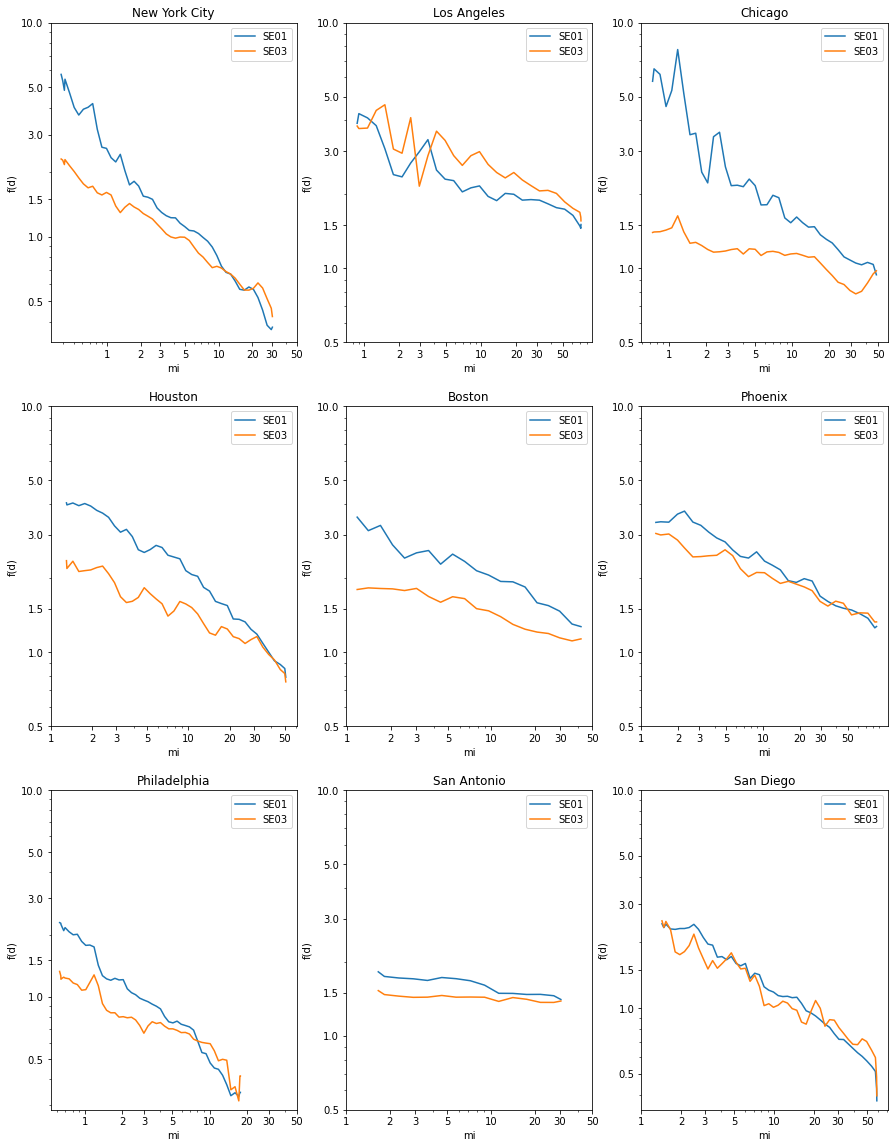

In [226]:
# 0.2% / 2000

fig,ax = plt.subplots(3,3,figsize=(15,20))
i= 0
for city,state, counties in cities:
    if city in citieeList:


        ax[i//3,i%3].plot(Distfd1[city].keys(),Distfd1[city].values(),label='SE01')

        ax[i//3,i%3].plot(Distfd3[city].keys(),Distfd3[city].values(),label='SE03')


        ax[i//3,i%3].set_title(city)
        ax[i//3,i%3].legend()
        ax[i//3,i%3].set_yscale('log')
        ax[i//3,i%3].set_xscale('log')
        ax[i//3,i%3].set_yticks([0.5, 1, 1.5, 3, 5, 10])
        ax[i//3,i%3].set_xticks([1, 2, 3, 5, 10, 20, 30, 50])
        ax[i//3,i%3].get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax[i//3,i%3].set_ylabel('f(d)')
        ax[i//3,i%3].set_xlabel('mi')
        i += 1

# plt.savefig('img/curve.png')